# IMDB RNN

## #01. 텍스트 분석 알고리즘

### 1. 텍스트 분석을 위해 개선된 알고리즘의 종류

#### RNN

- Embedding층은 단순하게 데이터의 표현을 학습하여 데이터 사전을 구축하는 것
- 하지만 유사한 의미의 단어를 비슷한 공간에 매핑할 수 있지만, 시퀀스 데이터의 중요한 특성인 순서와 맥락까지 고려한 것은 아니다.
- 순환 신경망은 이 문제를 해결하기 위해 고안된 층
- 완전연결층, 컨볼루션 신경망의 반대되는 개념.
- 완전연결층과 컨볼루션 신경망은 피드 포워드 네트워크(feed-forward network)라고 표현
- 피드 포워드 네트워크는 신경망이 가지는 모든 출력값이 마지막층인 출력층을 향한다.
- 하지만 순환 신경망은 각 층의 결과값이 출력층을 향하면서도 동시에 현재 층의 다음 계산에 사용된다.

#### LSTM

- RNN의 그래디언트 손실문제를 보완한 방법
- 정보를 여러 시점에 걸쳐 나르는 장치(‘Cell state’)가 추가되었다.
- 이로 인해 그래디언트를 보존할 수 있어 그래디언트 손실 문제가 발생하지 않도록 도와준다.

#### GRU

- 게이트 메커니즘이 적용된 RNN의 일종으로 LSTM에서 영감을 받았으며 더 간략한 구조를 갖는다.
- 한국인 조경현 박사님이 제안한 방법

### 2. 텍스트 분석 알고리즘 적용하기

전체 소스코드는 지금까지의 예제들과 동일하게 진행된다.

```
💡 패키지 준비 → 데이터셋 준비 → 데이터 전처리 → 탐색적 데이터 분석(문자열 토큰화, 데이터를 동일한 길이로 맞추기) → 데이터 셋 분할 → 모델 개발(정의+학습) → 학습 결과 평가 → 학습결과 적용
```

이 과정에서 학습 모델을 정의하는 부분에서 적용할 알고리즘만 변경하면 되기 때문에 여기서는 RNN을 먼저 적용해 본 후, 학습 모델을 LSTM과 GRU로 각각 변경하여 다시 학습을 수행해 보도록 한다.

학습 시간이 매우 오래 걸리는 예제이므로 가급적 GPU가 탑재된 컴퓨터에서 실습하는 것이 좋다.

## #02. 패키지 준비하기

In [1]:
import helper
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## #03. 데이터셋 준비

In [2]:
# 가장 빈번하게 사용되는 단어의 개수.
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

17464789/17464789 [==============================] - 0s 0us/step
훈련 데이터 (25000,) 레이블 (25000,)
검증 데이터 (25000,) 레이블 (25000,)


## #04. 데이터 전처리

### 1. 데이터를 동일한 길이로 맞추기 (padding)

In [3]:
# 최대 문장 길이
max_len = 500

print('Before pad_sequences: ', len(x_train[0]), len(x_train[1]))

pad_x_train = pad_sequences(x_train, maxlen=max_len, padding = 'pre')
pad_x_test = pad_sequences(x_test, maxlen=max_len, padding = 'pre')

#  원래 단어의 앞에 ‘지정해준 단어의 길이 – 원래 단어의 길이’(500 –218)만큼 0이 추가된 것을 볼 수 있다.
print('After pad_sequences: ', len(pad_x_train[0]), len(pad_x_train[1]))

print(pad_x_train[0])

Before pad_sequences:  218 189
After pad_sequences:  500 500
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

## #05. 데이터셋 분할하기

이미 데이터셋이 훈련데이터와 검증데이터로 분리되어 있기 때문에 별도의 분할 작업을 수행할 필요는 없다.

## #06. 모델 개발

### 모델 정의 (RNN)

return_sequences 파라미터가 True로 지정되면 모든 학습 시점의 은닉 상태를 출력해 준다. False인 경우는 마지막 시점의 은닉 상태만 출력한다. (기본값=False)

dropout은 지정된 비율만큼 학습을 건너뛰게 하는 파라미터. 이 파라미터를 사용하게 되면 과거 학습정보를 잃어버릴 확률이 높아지고 그에 따라 모델 성능이 나빠질 가능성이 있다.

recurrent_dropout(순환드롭아웃)은 과거 학습정보를 잃어버리는 문제를 해결하기 위해 적용하는 옵션.

In [4]:
model = Sequential()

model.add(Embedding(input_dim = num_words, output_dim = 32, input_length = max_len))
model.add(SimpleRNN(32, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))
model.add(SimpleRNN(16))
model.add(Dense(1, activation='sigmoid'))

# 결국은 긍정, 부정을 분류 하는 문제이므로 이진분류에 해당한다.
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 500, 32)           2080      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 322881 (1.23 MB)
Trainable params: 322881 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [5]:
result = model.fit(pad_x_train, y_train, epochs=500, validation_data=(pad_x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
782/782 [==============================] - 807s 1s/step - loss: 0.6922 - acc: 0.5294 - val_loss: 0.6833 - val_acc: 0.5488 - lr: 0.0010
Epoch 2/500
782/782 [==============================] - 736s 941ms/step - loss: 0.6416 - acc: 0.6285 - val_loss: 0.5352 - val_acc: 0.7399 - lr: 0.0010
Epoch 3/500
782/782 [==============================] - 701s 897ms/step - loss: 0.5720 - acc: 0.7099 - val_loss: 0.6167 - val_acc: 0.6992 - lr: 0.0010
Epoch 4/500
782/782 [==============================] - 686s 877ms/step - loss: 0.5114 - acc: 0.7589 - val_loss: 0.4748 - val_acc: 0.7883 - lr: 0.0010
Epoch 5/500
782/782 [==============================] - 680s 870ms/step - loss: 0.4595 - acc: 0.7916 - val_loss: 0.4351 - val_acc: 0.8016 - lr: 0.0010
Epoch 6/500
782/782 [==============================] - 688s 879ms/step - loss: 0.5065 - acc: 0.7621 - val_loss: 0.6375 - val_acc: 0.6282 - lr: 0.0010
Epoch 7/500
782/782 [==============================] - 701s 897ms/step - loss: 0.5089 - acc: 0.7584 - v

## #06. 학습결과 평가

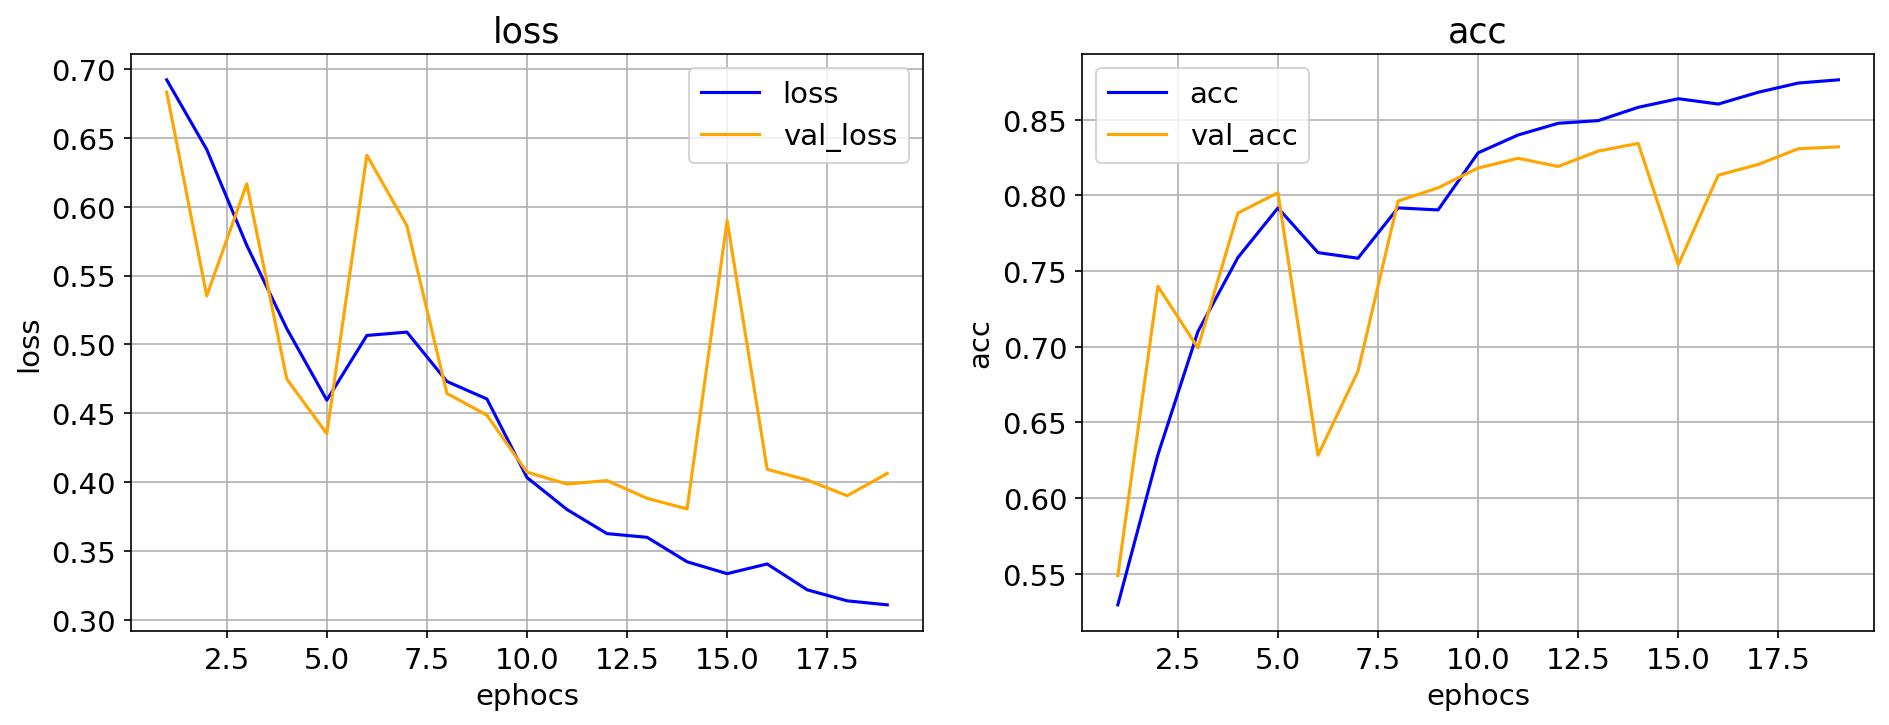

782/782 [==============================] - 58s 74ms/step - loss: 0.2546 - acc: 0.9014
최종 훈련 손실률: 0.254562, 최종 훈련 정확도: 0.901360
782/782 [==============================] - 58s 74ms/step - loss: 0.4062 - acc: 0.8320
최종 검증 손실률: 0.406196, 최종 검증 정확도: 0.832000


In [6]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(pad_x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(pad_x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #06. 학습 결과 적용

### 검증 데이터에 대한 예측 결과 산정

In [7]:
result = model.predict(pad_x_train)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

782/782 [==============================] - 60s 76ms/step
25000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.95889586],
       [0.03870387],
       [0.07933767],
       ...,
       [0.04890921],
       [0.94895816],
       [0.8883605 ]], dtype=float32)

### 예측 결과를 1차원 배열로 변환

In [8]:
f_results = result.flatten()
f_results

array([0.95889586, 0.03870387, 0.07933767, ..., 0.04890921, 0.94895816,
       0.8883605 ], dtype=float32)

### 실제 결과값과 머신러닝에 의한 예측값 비교

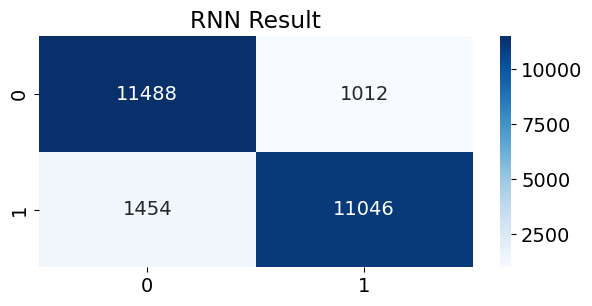

In [10]:
kdf = DataFrame({
    'train': y_train,
    'pred' : np.round(f_results)
})

kdf['pred'] = kdf['pred'].astype('int')

cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.title('RNN Result')
plt.show()
plt.close()